# Extracting high value lung ultrasound images from video for the diagnosis and prognosis of COVID-19.

This notebook is a step by step process through our work on lung ultrasound (LUS) image extraction. Our aim is to automate expert selection of image frames in a LUS video that have high clinical predictive value.

For this task, we decided to explore a supervised learning approach, using a binary CNN classifier able to distinguish LUS images based on their clinical predictive value. Our dataset is the Ultrason butterlfynetwork, which comprises images and videos of thoracic sites from patients recruited at the CHUV emergency room in Lausanne Switzerland between XX(date) and XX(date).

### Imports

In [1]:
from encoders import CnnEncoder
from cumulator import base
from plots import plot
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
import copy
import cv2
import seaborn as sns
import glob
import sys
%load_ext autoreload
%autoreload 2

## 1. Data Exploration

We first explore our dataset in order to gain comprehension of our data. We are interested in the distribution of images and videos, per patient and per thoracic site, as well as their formats.

### 1.1 Image format and count
We first count our images and videos, and check whether they all have the same formats.

In [2]:
butterfly_img_paths = glob.glob("data/Ultrason_butterflynetwork/*.png")
butterfly_vid_paths = glob.glob("data/Ultrason_butterflynetwork/*.mp4")

def count_img_formats(path_list):
    """
    Count each occurence of formats in the given list of images path
    
    path_list: list(str)
    """
    counts = {}
    for path in path_list:
        key = cv2.imread(path).shape
        if key not in counts.keys():
            counts[key] = 0
        else:
            counts[key] = counts[key] + 1
            
    print("=== Images ===")
    for format_ in counts.keys():
        print(f"Occurences of format {format_}: {counts[format_]}")
        
def count_vid_formats(path_list):
    """
    Count each occurence of formats in the given list of videos path, by looking at the format of the first frame of the video
    
    path_list: list(str)
    """
    counts = {}
    for path in path_list:
        video = cv2.VideoCapture(path)
        success, img = video.read()
        
        if success == False :
            raise(f"Video {path} can not be read")
        
        key = img.shape
        video.release()
        if key not in counts.keys():
            counts[key] = 0
        else:
            counts[key] = counts[key] + 1
            
    print("=== Videos ===")    
    for format_ in counts.keys():
        print(f"Occurences of format {format_}: {counts[format_]}")

In [3]:
count_img_formats(butterfly_img_paths)
count_vid_formats(butterfly_vid_paths)

=== Images ===
Occurences of format (1080, 791, 3): 3453
Occurences of format (1080, 790, 3): 2
=== Videos ===
Occurences of format (1080, 792, 3): 1265


First of all, we get that we have 3455 images in our dataset, and 1265 videos.

We see that not all images have the exact same format, which will require us to implement a resizing step in our pre-processing pipeline. It seems however, that our videos do share the same format. Considering that most of our images in the dataset come from videos, we may ask ourselves if this format difference may be explained by an eventual difference accross the frames of a video.

Let's inspect more precisely our videos:

In [4]:
def count_formats_one_vid(vid_path):
    """
    For a single video, count all frame formats
    """
    counts = {}
    video = cv2.VideoCapture(vid_path)
    while(video.isOpened()):
        success, img = video.read()
        
        if success == False :
            video.release()
            break
        key = img.shape
        if key not in counts.keys():
            counts[key] = 0
        else:
            counts[key] = counts[key] + 1
    return counts

In [5]:
one_vid_path = butterfly_vid_paths[0]
count_formats_one_vid(one_vid_path)

{(1080, 792, 3): 232}

It seems to not be the case. We don't really know where (in most of the cases) this 1 column of pixels went when people saved those images...

### 1.2 Data distribution per site
When a clinician performs a lung ultrasound (LUS) examination, he generally acquires several images on different thoracic sites. Each lung is partitioned in four quadrants (anterior or posterior and superior or inferior). They also perform one lung ultrasound on the side of the lung which implies that a patient could have up to 10 different videos of his lungs.

Here we look how is our data distributed according to each site:

In [6]:
def count_sites(paths_list):
    """
    Count the number of occurences of each thoracic sites
    
    paths_list: list(str)
    """
    site_nb = {}
    for data_path in paths_list:
        site_ext = data_path.split('_')[2]#get the site
        site = site_ext.split(".")[0]#removes the extension
        
        if site not in site_nb.keys():
            site_nb[site] = 1
        else:
            site_nb[site] = site_nb[site] + 1
    return site_nb

def plot_sites(paths_list):
    """
    Plot the distribution of sites
    
    paths_list: list(str)
    """
    
    butterfly_site_nb = dict(sorted(count_sites(paths_list).items()))
    plt.figure(figsize=(9,5))
    plt.bar(butterfly_site_nb.keys(), butterfly_site_nb.values())
    plt.title('Image count per site')
    plt.ylabel("Number of images")
    plt.xlabel('Sites')
    plt.show()

In [8]:
#Some files had misspellings, we take fix this here by modifying their names:
old_path = 'data/Ultrason_butterflynetwork/1.46_QAiG_1.png'
new_path = old_path.replace("QAiG", "QAIG", 1)
print(new_path)
os.rename(old_path, new_path)

old_path2 = 'data/Ultrason_butterflynetwork/1.156_QASD-1.png'
new_path2 = old_path2.replace("QASD-1", "QASD_1")
print(new_path2)
os.rename(old_path2, new_path2)

data/Ultrason_butterflynetwork/1.46_QAIG_1.png
data/Ultrason_butterflynetwork/1.156_QASD_1.png


FileNotFoundError: [WinError 2] Le fichier spécifié est introuvable: 'data/Ultrason_butterflynetwork/1.156_QASD-1.png' -> 'data/Ultrason_butterflynetwork/1.156_QASD_1.png'

In [44]:
butterfly_img_path = glob.glob("data/Ultrason_butterflynetwork/*.png")
butterfly_img_site_nb = dict(sorted(count_sites(butterfly_img_path).items()))
butterfly_img_site_nb

{'QAID': 352,
 'QAIG': 337,
 'QASD': 380,
 'QASG': 368,
 'QLD': 219,
 'QLG': 212,
 'QPID': 341,
 'QPIG': 331,
 'QPSD': 379,
 'QPSG': 366}

Unknown sites UNK and QASP are considered as outliers and removed from the dataset.

In [10]:
remove_paths = glob.glob("data/Ultrason_butterflynetwork/*UNK*") + glob.glob("data/Ultrason_butterflynetwork/*QASP*")
for path in remove_paths:
    os.remove(path)

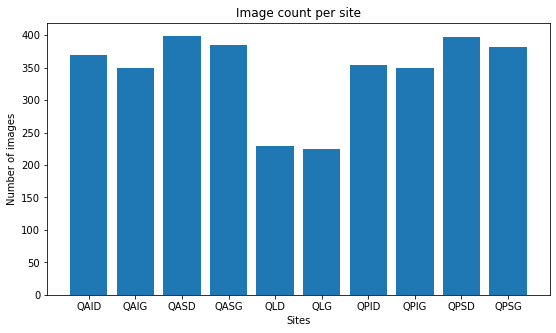

In [11]:
# Plotting the sites distribution
butterfly_img_path = glob.glob("data/Ultrason_butterflynetwork/*.png")
plot_sites(butterfly_img_path)

The images are rather uniformly distributed except for sites QLD and QLG, which have around have around 220 images while the others have 350-400 images per site.
We now proceed to the same analysis on videos.

In [12]:
#Same problem here as before, fixing misspellings
old_path = 'data/Ultrason_butterflynetwork/1.195_QlG.mp4'
new_path = old_path.replace("QlG", "QLG", 1)
print(new_path)
os.rename(old_path, new_path)

old_path2 = 'data/Ultrason_butterflynetwork/1.184_QAiD_1.mp4'
new_path2 = old_path2.replace("QAiD", "QAID")
print(new_path2)
os.rename(old_path2, new_path2)

data/Ultrason_butterflynetwork/1.195_QLG.mp4
data/Ultrason_butterflynetwork/1.184_QAID_1.mp4


In [13]:
butterfly_vid_path = glob.glob("data/Ultrason_butterflynetwork/*.mp4")
butterfly_vid_site_nb = dict(sorted(count_sites(butterfly_vid_path).items()))
butterfly_vid_site_nb

{'QAID': 129,
 'QAIG': 97,
 'QASD': 36,
 'QASG': 47,
 'QLD': 294,
 'QLG': 319,
 'QPAG': 2,
 'QPID': 156,
 'QPIG': 128,
 'QPSD': 34,
 'QPSG': 22}

In [14]:
remove_paths = glob.glob("data/Ultrason_butterflynetwork/*QPAG*")
for path in remove_paths:
    os.remove(path)

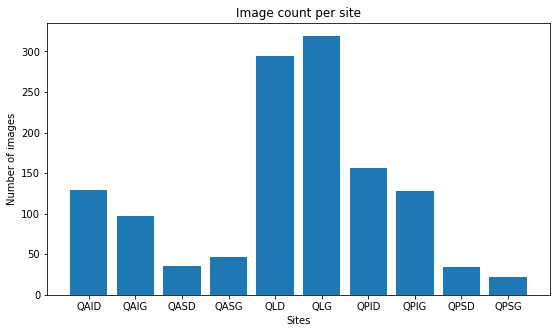

In [15]:
# Plotting the sites distribution
butterfly_vid_path = glob.glob("data/Ultrason_butterflynetwork/*.mp4")
plot_sites(butterfly_vid_path)

Surprisingly, we have a lot more QLD and QLG videos. We know that experts didn't extract an image from every videos or could extract multiple from one. This is why we have this difference between the images distribtution and the video distribution.

### 1.3 Data distribution per patient

Having studied the distribution per site, we are now interested in the way images and videos are distributed among patients. We start by counting the number of videos per patient and plot the corresponding histograM.

In [16]:
def patients_videos(vid_path_list):
    """
    Counts the number of videos per patient
    
    vid_path_list: list(str), list of paths of videos
    Returns: dict, Dictionnary with patient number (name) and number of videos associated to him 
    """
    patients = {}
    for path in vid_path_list:
        splitted_path = path.split('_') #split the path
        patient = splitted_path[0][-1] + "_" + splitted_path[1] #extract the patient's number
        if patient not in patients.keys():
            patients[patient] = 1
        else:
            patients[patient] = patients[patient] + 1
    return patients

In [17]:
nb_patients_videos = patients_videos(butterfly_vid_paths)
print(f"We have {len(nb_patients_videos.keys())} patients with videos")

We have 193 patients with videos


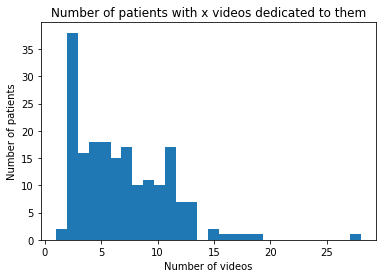

In [18]:
# Plotting video distribution per patient
plt.hist(nb_patients_videos.values(), bins = max(nb_patients_videos.values()))
plt.title('Number of patients with x videos dedicated to them')
plt.xlabel('Number of videos')
plt.ylabel('Number of patients')
plt.show()

The figure provides two different insights. First, there is a majority of patients with lower video counts, and second, there must be patients that have multiple video for the same site.

Hence we are interested in knowing how many patients actually have videos for each site.

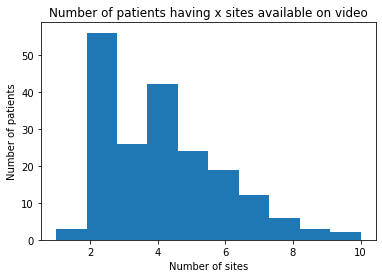

In [19]:
def sites_per_patient_videos(vid_path_list):
    """
    For each patient, counts the number of sites represented in their associated videos
    
    vid_path_list: list of paths of videos
    Returns: Dictionnary with patient number (name) and all sites that were performed on him
    """
    patients = {}
    for path in vid_path_list:
        splitted_path = path.split('_') #get the patient and the
        patient = splitted_path[0][-1] + "_" + splitted_path[1]
        
        site = splitted_path[2] #get the name of the video
        site = site.split(".")[0] #removes the extension
        
        if patient not in patients.keys():
            patients[patient] = set([site])
        else:
            patients[patient].add(site)
    return patients

sites_per_patient_dic = sites_per_patient_videos(butterfly_vid_paths)
nb_sites_per_patient = { k : len(v) for k,v in sites_per_patient_dic.items()}

plt.hist(nb_sites_per_patient.values(), bins = max(nb_sites_per_patient.values()))
plt.title('Number of patients having x sites available on video')
plt.xlabel('Number of sites')
plt.ylabel('Number of patients')
plt.show()

From the figure we can observe that almost no patient has a video for each site. This result could potentially be a limitation for our model training, and considerations should be made for future data collection in order to obtain a more even and complete representation.

## 2. Creating Datasets

In order to train our classifier, we require an image dataset with two different kind of labels:

* "True" images: selected by expert clinicians, these images are known to well represent a patient site and its useful features (such as pleural line, A-lines, B-lines ... etc).
* "False" images: taken from an LUS video, these images were not selected by an expert clinicians thus they do not represent the perfect shot for a given patient site (image can be blurry, features could be missing or capture angle can be wrong, thus making images difficult to interpret).

Our initial data contains roughly a thousand expert selected images, which intuitively form our "True" labeled images. However, we do not have any image that would correspond to our "False" label. Therefore we have to generate them ourselves. We use the following methodology to accomplish our goal:

For a given "True" image, we iterate through images from its corresponding video. For each of these candidate images, we compute a similarity value to the "True" image and select the candidate image as a False-labelled one based on this criteria. We require that the expert image and the selected image are not too similar to each other (since it would make the classification too hard), yet they should not be too different either (in order to better simulate the clinician options when selecting the best image). The details of the similarity metric are explained in later sections. 


### 2.1 Creating file folders

First of all, we need to define a function that creates folders that will contain our data. These follow a specific architecture that enables us to use PyTorch Datasets and Dataloaders classes conveniently.

In [54]:
def make_directory(path):
    """
    Create PyTorch compatible folder architecture
    """
    ! mkdir $path
    for kind in ['train/', 'val/']:
        sub_path = path + kind
        ! mkdir $sub_path
        for label in ['true', 'false']:
            full_path = sub_path + label
            ! mkdir $full_path

### 2.2 Image preprocessing

Raw images in the dataset are not ready to be used for training. Indeed, they are non biological features on the images, such as the image scale or the name of the corresponding site, that have to be removed in order to train our model without bias. These features can be visualized on the following image.

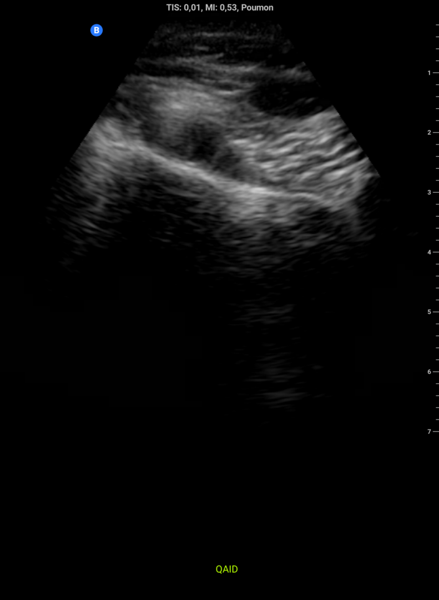

In [21]:
# Visualise a raw image
raw_img = Image.open("data/Ultrason_butterflynetwork/1.10_QAID.png")
raw_img.thumbnail((600, 600))
raw_img

Four features are to be removed, the lower and upper text, the blue B in the upper left corner, and the image scale on the right. To do so, we create a mask that we will use to crop images. The mask has been crafted manually, as we did not have time to implement automatic edge detrection or similar mechanism to automate the process. We also define a couple functions for common preprocessing operations.

In [22]:
# Main mask used to capture the relevant portion of LUS images. Crafted manually. Is [1,1,1] where image is relevant

# Image dimensions
nb_rows = 1080
nb_cols = 792
nb_channels = 3

mask = np.zeros([nb_rows, nb_cols, nb_channels])

# Filling mask
for row in range(nb_rows):
    for col in range(nb_cols):
        # Delimitations of the cone like portion of a LUS image
        if row > 25 and row < 1010 and col < 762 and (-4/5 * row + 293) < col and (4/5*row) + nb_cols-293 > col:
            mask[row, col] = [1,1,1]

mask = mask.astype('uint8')
            
            
def resize_crop(image, mask, nb_cols=792, nb_rows=1080):
    """
    Resize image and apply mask
    """
    masked_img = cv2.resize(image, (nb_cols, nb_rows))*mask
    return masked_img


def read_crop(image_path, mask, nb_cols=792, nb_rows=1080):
    """
    Read image, resize to given dimensions and apply mask.
    
    Returns: image name, image
    """
    # Reading and masking image
    cv2_img = cv2.imread(image_path)
    masked_img = resize_crop(cv2_img, mask, nb_cols, nb_rows)

    # Selecting image name from path name
    img_name = os.path.split(image_path)[-1]
    
    return img_name, masked_img

### 2.3 Obtaining Test images

Before any dataset generation, we need to select and exclude a few images and video for model testing purposes. We selected ten patient IDs by hand. These patients present the advantage of having images and corresponding videos for most of the sites.

In [23]:
# Create test data folder
! mkdir data/test
! mkdir data/test/test

# patient ids used for the test set
test_ids = ['.151_','.136_', '.117_', '.45_', '.16_', '.77_', '.164_', '.57', '.36_', '.157_']

files_path = glob.glob("data/Ultrason_butterflynetwork/*")
test_files = [file for file in files_path if any([(id_ in file) for id_ in test_ids])]

for file in test_files:
    img_name = os.path.split(file)[-1]
    os.rename(file, f"data/test/test/{img_name}")

La syntaxe de la commande n'est pas correcte.
La syntaxe de la commande n'est pas correcte.


### 2.3 Obtaining Training and Validation images

We now proceed to dataset generation. First let us define our image similarity mechanism. 

#### 2.3.1 Similarity between two images

The similarity measure was inspired to us by ([Yang et al.](https://arxiv.org/abs/1706.04737), 2017). The idea is to encode images to lesser dimensional formats, reshape them as vector, and finally compute their cosine similarity. The encoding process is necessary to reduce complexity. Encoding can be done in various ways. In our project, we selected two methods:
* Computing the mean brightness for a couple subparts of the image, in a convolutional fashion.
* Using a pretrained CNN model (resnet18) stripped from its last layers, as an encoder

The function ```create_brightness_matrix``` implements the first method. The second method is handled by the CnnEncoder class from the encoder.py file.

In [29]:
def create_brightness_matrix(img, mask=mask, side_length=200):
    """
    Split the image in a couple subparts for which the mean brightness is computed
    """
    img = resize_crop(img, mask)
    # half_side determines the number of pixels per step of the "convolution"
    half_side = int(side_length / 2)
    nb_rows = img.shape[0] // half_side
    nb_cols = img.shape[1] // half_side
    matrix = np.zeros((nb_rows, nb_cols))
    
    for i in range(nb_rows) :
        for j in range(nb_cols) :
            matrix[i, j] = np.mean(img[half_side * i : half_side * i + side_length, half_side * j : half_side * j + side_length]) / 3
    
    return matrix


def cosine_similarity(vector1, vector2):
    """
    Compute the cosine similarity between two vectors of the same size
    """
    return np.dot(vector1,vector2)/(np.linalg.norm(vector1)*np.linalg.norm(vector2))

In [32]:
# Displaying encoded images shapes
img = cv2.imread(butterfly_img_path[0])

# First method
print(f"Image of format {img.shape} is encoded to format {create_brightness_matrix(img).shape}")

# Second method
cnn = CnnEncoder()
cnn = cnn.eval()
print(f"Image of format {img.shape} is encoded to format {cnn(img).shape}")

Image of format (1080, 791, 3) is encoded to format (10, 7)
Image of format (1080, 791, 3) is encoded to format torch.Size([1, 4, 4])


#### 2.3.2 Generating datasets

#### 2.3.2.1 Selection based on brightness
Before trying our selection based on the similarity, we tried a naive approach which was to consider that the mean brightness over all the image was sufficient to descriminate *True* frome *False image*. The idea is that an image where there is no information will always be bad (wave hits a bone) , and one that is too bright will also be bad.

We first create datasets structure



In [55]:
dataset_path = "data/butter_proc_images_mean_brightness/"
make_directory(dataset_path)

La syntaxe de la commande n'est pas correcte.
La syntaxe de la commande n'est pas correcte.
La syntaxe de la commande n'est pas correcte.
La syntaxe de la commande n'est pas correcte.
La syntaxe de la commande n'est pas correcte.
La syntaxe de la commande n'est pas correcte.
La syntaxe de la commande n'est pas correcte.


##### Generate true images
We define a function that selects a number of samples true samples, crops them, and put them in the train or val folder according to the train ratio

In [62]:
def generate_true_for_mean_brightness(nb_samples, ratio, read_path, write_path, mask):
    """
    Crops nb_spamples images from the given folder and 
    organises them in training, validation folders, in "true" labeled subfolders
    """
    images_path = glob.glob(read_path)
    
    # sparating test images and shuffling
    np.random.seed(1)
    images_path = [img for img in images_path if not any([(id_ in img) for id_ in test_ids])]
    images_path = np.random.permutation(images_path)
    
    train = int(nb_samples * ratio)

    # Writing training and validation images to folder
    for i, image in enumerate(images_path[:nb_samples]):
        img_name, masked_img = read_crop(image, mask)
        
        if i >= train:
            cv2.imwrite(f"{write_path}/val/true/{img_name}", masked_img)
        else:
            cv2.imwrite(f"{write_path}/train/true/{img_name}", masked_img)

In [61]:
#Fills the datasets with the true samples
nb_samples = 1000 #There should be only 3285 samples in the whole dataset
train_ratio = 0.8
read_path = "data/Ultrason_butterflynetwork/*.png"

generate_true_for_mean_brightness(nb_samples, train_ratio, read_path, dataset_path, mask)

##### Generate false images
We first want to know what hyperparameters makes sens to select we need to select in order to not make dumb predictions. So we first create a function that computes the mean over the masked area

In [63]:
def compute_mean(img, mask):
    """
    Computes the mean brightness over the masked area
    """
    active = np.sum(mask)/nb_channels
    mean = np.mean(img)*(nb_cols*nb_rows/active)

    return mean

We create the function create_brightness_df that will have the brightness over all expert images, We will then use the method describe to know how does our dataset look like and plot the histogram to see the distribution.

In [72]:
def create_brightness_df(images_path_list, mask):
    """
    Creates a dataframe that contains all mean values in the sample paths
    """
    df = pd.DataFrame(columns = ['mean'])
    for i,image in enumerate(images_path_list):
        img = cv2.imread(image)
        m = compute_mean(img, mask)
        df.loc[i] = [m]
        
    return df

In [73]:
train_img_path = glob.glob("data/butter_proc_images_mean_brightness/train/true/*.png") #can only have infos over our train sample
brightness_df = create_brightness_df(train_img_path, mask)

In [74]:
brightness_df.describe()

,mean
count,800.000000
mean,28.918892
std,13.274421
min,5.022914
25%,19.129459
50%,26.711118
75%,36.784782
max,85.383995


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001DCE7DE4788>]],
      dtype=object)

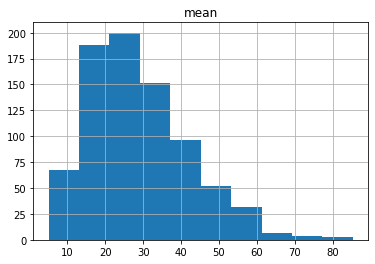

In [75]:
brightness_df.hist()

Observing how the dataset is distributed, we consider that the images that are less than the standard deviation are considered as outliers, we thus select this result as hyperparameters to select our images.

In [96]:
# TODO justify these
MEAN_DOWN, MEAN_UP = 15, 41 #mean_down, mean_up ( ~= mean +- std )
LAST_SEEN_NB_FRAMES = 40

In [98]:
#Seems to depend on the OS
def do_split(path) :
    '''
    Splits the path according to the OS
    '''
    if(sys.platform.startswith('linux')) :
        return path.split('/')
    else :
        return path.split('\\')

The two following methods allow to create *False* samples in the train and val set based on the the two parameters ```MEAN_DOWN``` and ```MEAN_UP``` we previously set.

In [101]:
#Creates samples from a video
def create_false_samples_from_video(read_path, write_path, max_count, sample_count=0):
    """
    Select images from videos based on brightness criteria and write them to the corresponding folder
    Can not select more than max_count images
    Images have to be separated by a minimum number of frames in the video as to avoid selecting nigh identical images.
    """
    video = cv2.VideoCapture(read_path)
    i = 0
    last_write = 100 #variable to avoid writing 2 successive images
    
    while(video.isOpened() and sample_count < max_count):
        ret, image = video.read()
        if ret == True:
            #if we have access to an image, we check the mean, after applying the mask
            image = image * mask
            mean = compute_mean(image, mask)
            
            if (mean > MEAN_DOWN or mean < MEAN_UP) and (last_write > LAST_WRITE_NB_FRAMES) :
                video_id = do_split(read_path)[-1].split('.')[-2]
                cv2.imwrite(f"{write_path}/{video_id}_{i}.png", image)
                sample_count = sample_count + 1
                i+=1
                last_write = 0
            
            last_write += 1
        else:
            #need to get out the while loop if we can't read a file
            break
    video.release()
    return sample_count

In [102]:
def generate_false_samples_from_videos(read_path, write_path, nb_samples, train_ratio, test_ids):
    """
    Obtain nb_samples images from videos based on brightness criteria
    and splits them between the training and validation folders
    Obtain images for the test ids
    """
    np.random.seed(1)
    path = np.random.permutation(glob.glob(read_path))
    videos_path_test = [img for img in path if any([(id_ in img) for id_ in test_ids])] #WE DON'T SELECT VIDEOS IN TEST
    videos_path = [img for img in path if not any([(id_ in img) for id_ in test_ids])]
        
    nb_samples_train = int(nb_samples * train_ratio)
    sample_count = 0
        
    # Writing training and validation images to respective folders
    for video_path in videos_path:
        if sample_count >= nb_samples:
            break
        elif sample_count < nb_samples_train:
            sample_count = create_false_samples_from_video(video_path, f"{write_path}/train/false", max_count=nb_samples, sample_count=sample_count)
        else:
            sample_count = create_false_samples_from_video(video_path, f"{write_path}/val/false", max_count=nb_samples, sample_count=sample_count)
        
    
    if sample_count < nb_samples:
        print(f"Could not obtain enough samples: \nObtained : {sample_count} \nDemanded: {nb_samples}")

In [103]:
#Generate the false images in the train and val samples. We generate as much False as True images.

read_path = "data/Ultrason_butterflynetwork/*.mp4"
generate_false_samples_from_videos(read_path, dataset_path, nb_samples, train_ratio, test_ids)

KeyboardInterrupt: 

#### 2.3.2.2 Selection based on similarity

Armed with an encoder and a similarity measure, we can now tackle the image selection problem. We will proceed as described in Section 2.

The function ```generate_dataset``` iterates through images present in the given folder, namely the Ultrason butterflynetwork one. For each of these expert selected image, the function tries to find a corresponding (same patient, same site) video through the function ```find_video```. If such video is found, the ```extract_similar_image``` function then iterates through the video, computing the similarity measure between the video's frames and the expert image, in a sequential fashion. If a given frame satisfies the similarity criterias (not too different, not too similar), then both the expert image and the selected frames are saved in their respective folder, namely the True and False labelled ones.

Whenever a frame does not satisfy the similarity criterias, we do not compute similarity for the next couples frames because these are likely to give the same results considering there is very little change between two successive images in a video. This allows us to slightly reduce time complexity. The variable ```LAST_SEEN_NB_FRAMES``` represents this amount of skipped frames.

In [40]:
LAST_SEEN_NB_FRAMES = 40

def generate_dataset(read_path, write_path, encoder, min_similarity, max_similarity, nb_samples=300 , train_ratio=0.8):
    """
    Creates samples for training and validation sets, using an image similarity criteria.
    """
    
    np.random.seed(1)
    images_path = read_path + '.png'
    images_path = np.random.permutation(glob.glob(images_path))
    images_path = [img for img in images_path if not any([(id_ in img) for id_ in test_ids])] # ignore images used for testing
    
    videos_path = read_path + '.mp4'
    videos_path = set(glob.glob(videos_path)) # transformed to set for faster queries
    
    sample_count = 0
    
    # Writing training and validation images to respective folders
    for image_path in images_path:
        # Finding corresponding video
        success, video_path = find_video(image_path, videos_path)
        if success == True:
            if sample_count >= nb_samples:
                break
            else:
                count = extract_similar_image(image_path, video_path, f"{write_path}train/", encoder, min_similarity, max_similarity)
                sample_count += count
    
    # Moving some images to to validation folder
    nb_samples_val = int(sample_count - (sample_count * train_ratio)) # mandatory due to floating point precision
    move_to_val(f"{write_path}train/", f"{write_path}val/", nb_samples_val)
    
    print(f"Obtained : {sample_count} samples")
             
            
def move_to_val(img_path, val_path, nb_samples_val):
    """
    Move nb_samples_val images from the img_path folder to the val_path folder
    """
    img_to_move_false = glob.glob(img_path+'false/*')[:nb_samples_val]
    img_to_move_true = glob.glob(img_path+'true/*')[:nb_samples_val]
    val_path_false = val_path + 'false'
    val_path_true = val_path + 'true'
    
    for file_false, file_true in zip(img_to_move_false, img_to_move_true):
        !mv $file_false $val_path_false
        !mv $file_true $val_path_true

        
def extract_similar_image(image_path, video_path, write_path, encoder, min_similarity, max_similarity, mask=mask):
    """
    For a given image, extract a similar sample from the corresponding video (if it exists) and save it.
    """
    # Extracting and encoding the reference expert image
    exp_image = cv2.imread(image_path)
    exp_image_code = encoder(exp_image).reshape(-1)
    
    # Video exploitation
    video = cv2.VideoCapture(video_path)
    last_seen = LAST_SEEN_NB_FRAMES # variable to avoid considering two sample images that are almost the same 
    extraction_success = False
    
    while(video.isOpened()):
        success, sample_image = video.read()
        if (success == True):
            if (last_seen >= LAST_SEEN_NB_FRAMES) :
                # If we have access to an image, we encode it and verify the similarity to the expert image
                sample_image_code = encoder(sample_image).reshape(-1)
                similarity = cosine_similarity(exp_image_code, sample_image_code)
                # If the similarity criterion is satisfied, the image is selected
                if (similarity > min_similarity and similarity < max_similarity):
                    
                    # Saving sampled image
                    _, image_id = os.path.split(image_path)
                    cv2.imwrite(f"{write_path}false/{image_id}", resize_crop(sample_image, mask))
                    
                    # Saving corresponding expert image
                    cv2.imwrite(f"{write_path}true/{image_id}", resize_crop(exp_image, mask))
                    
                    extraction_success = True
                    video.release()
                    break # cv2 does not release video fast enough
                else:
                    last_seen = 0
        else:
            #need to get out the while loop if we can't read a file
            video.release()
        last_seen += 1
    
    return extraction_success

        
def find_video(image_path, videos_path):
    """
    For a given unique image path, find if there is corresponding video in the given list of videos paths
    
    image_path: str, path of single image
    videos_path: set containing paths of all videos
    return: bool, str (operation success, video path)
    """
    video_path = image_path[:-4] + '.mp4'
    if(video_path in videos_path):
        return True, video_path
    else:
        return False, None

Generating the datasets.

In [41]:
similarity_bounds = [[0.75, 0.85], [0.8, 0.9], [0.85, 0.95], [0.9, 0.97]]
cnn = CnnEncoder()
cnn = cnn.eval()
encoders = [(create_brightness_matrix, 'brightMat'), (cnn, 'cnn')]
for bounds in similarity_bounds:
    for encoder in encoders:
        dataset_path = f'data/butter_proc_images_{encoder[1]}_{bounds[0]}_{bounds[1]}/'
        make_directory(dataset_path)
        print(f'\n ########## Encoder ({encoder[1]}) with similarity bounds ({bounds[0]}) and ({bounds[1]}) ##########\n')
        generate_dataset(read_path='data/Ultrason_butterflynetwork/*',
                         write_path=dataset_path,
                         encoder=encoder[0],
                         min_similarity=bounds[0],
                         max_similarity=bounds[1],
                         nb_samples=1000)


 ########## Encoder (brightMat) with similarity bounds (0.75) and (0.85) ##########

Obtained : 199 samples

 ########## Encoder (cnn) with similarity bounds (0.75) and (0.85) ##########

Obtained : 44 samples

 ########## Encoder (brightMat) with similarity bounds (0.8) and (0.9) ##########

Obtained : 292 samples

 ########## Encoder (cnn) with similarity bounds (0.8) and (0.9) ##########

Obtained : 111 samples

 ########## Encoder (brightMat) with similarity bounds (0.85) and (0.95) ##########

Obtained : 478 samples

 ########## Encoder (cnn) with similarity bounds (0.85) and (0.95) ##########

Obtained : 289 samples

 ########## Encoder (brightMat) with similarity bounds (0.9) and (0.97) ##########

Obtained : 550 samples

 ########## Encoder (cnn) with similarity bounds (0.9) and (0.97) ##########

Obtained : 428 samples


## 3. Model training

Having generated a couple of datasets with different similarity criterions, we can now train a model for each of those.

We explore transfer learning approaches for its benefits of computational efficiency.
In order to train our classifier, we use the ResNet18 model \cite{he2016deep} pretrained on the ImageNet dataset, on which we will perform fine tuning.
Note that the following training code is to a large extent inspired by an official PyTorch tutorial: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

We first define data and model loading functions.

In [112]:
# Data transformations

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


def get_data(data_path):
    """
    Organise data from the given folder into dataloaders and provides dataset sizes and class names
    """
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_path, x),
                                              data_transforms[x])
                      for x in ['train', 'val']}
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                                 shuffle=True, num_workers=4)
                  for x in ['train', 'val']}
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
    class_names = image_datasets['train'].classes
    
    return dataloaders, dataset_sizes, class_names
    
    
def get_model_and_parameters(model_type):
    """
    For the required model type, load and adapt pretrained model, and provide training modules
    """
    # Loading pretrained model
    if(model_type is "resnet18"):
        model = models.resnet18(pretrained=True)
    elif(model_type is "googlenet"):
        model = models.googlenet(pretrained=True)
    else:
        raise Error(f"Model {model_type} is not supported")
        
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2)

    model = model.to(device)

    criterion = nn.CrossEntropyLoss()

    # Fine tuning optimizer
    optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
    
    return model, criterion, optimizer_ft, exp_lr_scheduler

The model is trained over 25 epochs, using cross entropy loss and the Stochastic Gradient Descent with momentum ($\beta = 0.9$). Our initial learning rate value is $\gamma = 0.001$ and we use a learning rate optimizer that multiplies it by factor $0.1$ every $7$ epoch. We fine tune the model during training by allowing all the weights of the model to be retrained, and keep the version that performed the best validation accuracy during training.

In [113]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Storing training progression values
    losses_tr = []
    losses_val = []
    acc_tr = []
    acc_val = []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            # Storing loss and accuracy values
            if phase == 'train':
                losses_tr.append(epoch_loss)
                acc_tr.append(epoch_acc)
            else:
                losses_val.append(epoch_loss)
                acc_val.append(epoch_acc)
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}\n'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, losses_tr, losses_val, acc_tr, acc_val

We create folders for storing the models and then proceed to training on each dataset. As an additional metric, we are interested in keeping track of the carbon footprint caused by the training of the models. Indeed, long computation task involving GPU consume non negligible amount of energy and being aware of these issues is a required first step towards optimizing for better environmental impact. To do so, we make us of the [Cumulator](https://pypi.org/project/cumulator/) tool.

In [44]:
! mkdir models
! mkdir models/similarity
! mkdir models/mean_brightness
! mkdir figures

mkdir: cannot create directory ‘models’: File exists
mkdir: cannot create directory ‘figures’: File exists


#### Mean Brightness model
We first train our model on the dataset generated with the mean brightess of the images. 

In [116]:
model_type = "resnet18"

dataset_path = f'data/butter_proc_images_mean_brightness/'
dataloaders, dataset_sizes, class_names = get_data(dataset_path)
model, criterion, optimizer_ft, exp_lr_scheduler = get_model_and_parameters(model_type)
        
print(f'\n ########## Mean brightness ##########\n')
        
# Carbon footprint measurement
#cumulator = base.Cumulator()
#cumulator.on()
        
# Training model
#model_trained, losses_tr, losses_val, acc_tr, acc_val = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,
                                    #num_epochs=25)
#cumulator.off()
#print(f"Carbon footprint : {cumulator.total_carbon_footprint():.2f} gCO2eq")
        
# Saving model
torch.save(model.state_dict(), f"models/mean_brightness/{model_type}_natural_mean_brightness")
        
# Plotting
plot(acc_tr, acc_val, 'Training accuracy', 'Validation accuracy',\
     f'Accuracy Mean Brightness',\
     f'figures/accuracy_{model_type}_natural_mean_brightness.png', 'accuracy') #Notice we only have accuracy, no loss function


 ########## Mean brightness ##########



FileNotFoundError: [Errno 2] No such file or directory: 'models/similarity/resnet18_natural_mean_brightness'

#### Similarity based model

In [45]:
model_type = "resnet18"

for bounds in similarity_bounds:
    for encoder in encoders:
        dataset_path = f'data/butter_proc_images_{encoder[1]}_{bounds[0]}_{bounds[1]}/'
        dataloaders, dataset_sizes, class_names = get_data(dataset_path)
        model, criterion, optimizer_ft, exp_lr_scheduler = get_model_and_parameters(model_type)
        
        print(f'\n ########## Encoder ({encoder[1]}) with similarity bounds ({bounds[0]}) and ({bounds[1]}) ##########\n')
        
        # Carbon footprint measurement
        cumulator = base.Cumulator()
        cumulator.on()
        
        # Training model
        model_trained, losses_tr, losses_val, acc_tr, acc_val = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,
                                    num_epochs=25)
        cumulator.off()
        print(f"Carbon footprint : {cumulator.total_carbon_footprint():.2f} gCO2eq")
        
        # Saving model
        torch.save(model.state_dict(), f"models/similarity/{model_type}_natural_{encoder[1]}_{bounds[0]}_{bounds[1]}")
        
        # Plotting
        plot(losses_tr, losses_val, 'Training loss', 'Validation loss',
             f'Losses {bounds[0]}_{bounds[1]}', 
             f'figures/losses_{model_type}_natural_{encoder[1]}_{bounds[0]}_{bounds[1]}.png', 'loss')
        plot(acc_tr, acc_val, 'Training accuracy', 'Validation accuracy',
             f'Accuracy {bounds[0]}_{bounds[1]}',
             f'figures/accuracy_{model_type}_natural_{encoder[1]}_{bounds[0]}_{bounds[1]}.png', 'accuracy')


 ########## Encoder (brightMat) with similarity bounds (0.75) and (0.85) ##########

Epoch 0/24
----------


KeyboardInterrupt: 

## 4. Model testing

### 4.1 Loading the model

In [ ]:
def load_model(load_path, device, model_type):
    """
    Load model parameters into the corresponding model 
    """
    # Loading model architecture
    if(model_type is "resnet18"):
        model = models.resnet18(pretrained=True)
    elif(model_type is "googlenet"):
        model = models.googlenet(pretrained=True)
    else:
        raise Error(f"Model {model_type} is not supported")
        
    model = models.resnet18(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2)

    # Loading parameters to the model
    model.load_state_dict(torch.load(load_path))
    model = model.to(device)
    model.eval()
    
    return model

### 4.2 Testing

We can only measure our model's extraction power for models where we used the notion of similarity. For our selected test images, we iterate through the corresponding video running each frame into our model. The one frame that achieves highest confidence as a "True" image is to be selected. We then compute the similarity between our selected image and the expert one. This measure is our testing metric. The higher, the closer our model as been able to emulate the expert's decision. 

In [ ]:
def prepare_for_model(img):
    """
    Read image and apply required transformations for model usage
    """
    # Read, resize and crop
    img = resize_crop(img, mask)
    
    # Transform to PIL format
    img = Image.fromarray(img)
    
    # Images transformations to apply before entering model
    transform = transforms.Compose([
                    transforms.Resize(256),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    
    return transform(img)


def test_model(model, test_folder_path, encoder):
    """
    Test the given model on images and videos contained in the given folder, based on a similarity metric
    Return the average similarity between expert images and model selectd images from the corresponding videos
    """
    images_path = test_folder_path + 'test/*.png'
    images_path = glob.glob(images_path)
    
    videos_path = test_folder_path + 'test/*.mp4'
    videos_path = set(glob.glob(videos_path)) # transformed to set for faster queries
    
    similarities = []
    
    # Use model on image every 'skip' frames
    skip = 10
    
    for image_path in images_path:
        # Finding corresponding video
        success, video_path = find_video(image_path, videos_path)
        if(success == True):
            # Scanning the video
            video = cv2.VideoCapture(video_path)
            frame = 0
            best_confidence = 0
            selected_image = None
            while(video.isOpened()):
                success, sample_image = video.read()
                if(success == True):
                    frame += 1
                    if(frame % skip == 0):
                        # Sampled image goes through the model
                        model_image = prepare_for_model(sample_image)
                        model_image = torch.unsqueeze(model_image, 0) # adding dummy batch dimension
                        model_image = model_image.to(device)
                        probabilities = nn.functional.softmax(model(model_image), dim = 1)
                        confidence = probabilities[0,1]

                        if(confidence >= best_confidence):
                            best_confidence = confidence
                            selected_image = sample_image.copy()
                else:
                    video.release()
            
            # Computing similarity
            if selected_image is not None:
                exp_image = cv2.imread(image_path)
                exp_image_code = encoder(exp_image).reshape(-1)
                selected_image_code = encoder(selected_image).reshape(-1)
                similarity = cosine_similarity(exp_image_code, selected_image_code)
                similarities.append(similarity)
    
    return np.mean(similarities)

Computing average similarity over the test set:

In [ ]:
model_type = "resnet18"
test_folder_path = "data/test/"

for bounds in similarity_bounds:
    for test_encoder in encoders:
        for encoder in encoders:
            # Loading model
            model_path = f'models/similarity/{model_type}_natural_{encoder[1]}_{bounds[0]}_{bounds[1]}'
            model = load_model(model_path, device, model_type)
            print(f'\n ########## Model trained with encoder ({encoder[1]}) and similarity bounds ({bounds[0]}) - ({bounds[1]}), test similarity through {test_encoder[1]} ##########\n')

            # Testing
            mean_similarity = test_model(model, test_folder_path, test_encoder[0])
            print(f'Mean similarity on test set: {mean_similarity:.4f}')

In [ ]:
def generate_confident_images(model, test_folder_path, write_path):
    """
    Generates images in write_path given the videos in the test_folder_path according given the model.
    An image is considered as good if our model is more than 70% confident it's a good image, average between 20%-70%
    and bad when it's lower than 20%
    """   
    videos_path = test_folder_path + 'test/*.mp4'
    videos_path = glob.glob(videos_path)
    
    good_counter = 0
    avg_counter = 0
    bad_counter = 0
    
    # Use model on image every 'skip' frames
    skip = 1
    # TODO debug stuff
    #images_path = images_path[:3]
    #print(images_path)
    
    for video_path in videos_path:
        # Scanning the video
        video = cv2.VideoCapture(video_path)
        frame = 0
        best_confidence = 0
        min_best_confidence = 0.7
        selected_image = None
        average_image = None
        bad_image = None
        while(video.isOpened()):
            success, sample_image = video.read()
            if(success == True):
                frame += 1
                if(frame % skip == 0):
                    # Sampled image goes through the model
                    model_image = prepare_for_model(sample_image)
                    model_image = torch.unsqueeze(model_image, 0) # adding dummy batch dimension
                    model_image = model_image.to(device)
                    probabilities = nn.functional.softmax(model(model_image), dim = 1)
                    confidence = probabilities[0,1]
                    if((confidence >= min_best_confidence) and (confidence >= best_confidence)):
                        best_confidence = confidence
                        selected_image = sample_image.copy()
                    
                    if((average_image is None) and ((confidence < 0.7) and (confidence > 0.2))):
                        average_image = sample_image.copy()
                        
                    if((bad_image is None) and (confidence < 0.2)):
                        bad_image = sample_image.copy()                         
            else:
                video.release()

        # Writing images
        image_id = os.path.split(video_path)[-1][:-4] + '.png'
        if selected_image is not None:
            good_counter +=1
            cv2.imwrite(f"{write_path}best/{image_id}", resize_crop(selected_image, mask))
        
        if average_image is not None:
            avg_counter +=1
            cv2.imwrite(f"{write_path}average/{image_id}", resize_crop(average_image, mask))
        
        if bad_image is not None:
            bad_counter +=1
            cv2.imwrite(f"{write_path}bad/{image_id}", resize_crop(bad_image, mask))
            
    print("Good", good_counter)
    print("Average", avg_counter)
    print("Bad", bad_counter)

We need to create a folder where to put the selected images

In [ ]:
! mkdir data/selected_images
! mkdir data/selected_images/best
! mkdir data/selected_images/average
! mkdir data/selected_images/bad

In [ ]:
model_path = f'models/similarity/resnet18_natural_cnn_0.8_0.9'
model = load_model(model_path, device, model_type)
generate_confident_images(model, test_folder_path, 'data/selected_images/')

In [ ]:
#Test the brightness model

model_path = f'models/mean_brightness/{model_type}_natural_mean_brightness'
model = load_model(model_path, device, model_type)

print(f'\n ########## Model trained using mean dataset brightness ##########\n')
generate_confident_images(model, test_folder_path, 'data/selected_images/')

In [ ]:
#Test on all the model created with the similarity
for bounds in similarity_bounds:
    for encoder in encoders:
        # Loading model
        model_path = f'models/similarity/{model_type}_natural_{encoder[1]}_{bounds[0]}_{bounds[1]}'
        model = load_model(model_path, device, model_type)
        print(f'\n ########## Model trained with encoder ({encoder[1]}) and similarity bounds ({bounds[0]}) - ({bounds[1]}) ##########\n')
        generate_confident_images(model, test_folder_path, 'data/selected_images/')

In [ ]:
def give_confidence_test_set_images(model, test_folder_path):
    """
    Prints the score of our model on the test images (Which are all good)
    """   
    images_path = test_folder_path + 'test/*.png'
    images_path = glob.glob(images_path)
    
    
    # Use model on image every 'skip' frames
    skip = 10
    # TODO debug stuff
    #images_path = images_path[:3]
    #print(images_path)
    
    good_counter = 0
    avg_counter = 0
    bad_counter = 0
    
    for image_path in images_path:
        sample_image = cv2.imread(image_path)
        # Sampled image goes through the model
        model_image = prepare_for_model(sample_image)
        model_image = torch.unsqueeze(model_image, 0) # adding dummy batch dimension
        model_image = model_image.to(device)
        probabilities = nn.functional.softmax(model(model_image), dim = 1)
        confidence = probabilities[0,1]
        
        if confidence > 0.7:
            good_counter += 1
        elif confidence < 0.2:
            bad_counter +=1
        else:
            avg_counter += 1
            
    print("Good", good_counter)
    print("Average", avg_counter)
    print("Bad", bad_counter)

In [ ]:
model_path = f'models/similarity/resnet18_natural_brightMat_0.85_0.95'
model = load_model(model_path, device, model_type)
give_confidence_test_set_images(model, test_folder_path)

In [ ]:
model_path = f'models/similarity/resnet18_natural_cnn_0.75_0.85'
model = load_model(model_path, device, model_type)
give_confidence_test_set_images(model, test_folder_path)

In [ ]:
model_path = f'models/similarity/resnet18_natural_cnn_0.8_0.9'
model = load_model(model_path, device, model_type)
give_confidence_test_set_images(model, test_folder_path)

In [ ]:
cnn = CnnEncoder()
cnn = cnn.eval()
img1 = cnn(cv2.imread('data/Ultrason_butterflynetwork/1.21_QLD.png')).reshape(-1)

img2 = (np.random.rand(len(img1)) * 256).reshape(-1)
cosine_similarity(img1, img2)

In [ ]:
image_test = cv2.imread('data/test/test/1.16_QAID.png')
image_test = resize_crop(image_test, mask)
cv2.imwrite('image_test.png', image_test)

In [ ]:
img1 = cv2.imread('data/test/test/1.16_QAID.png')
img1.resize(1080,792,3)
print(len(img1.flatten()))
cosine_similarity(img1[500,200:210,0].reshape(-1), image_test[500,200:210,0].reshape(-1))

In [ ]:
img1 = cv2.imread('data/test/test/1.16_QAID.png')
img1[500,200:210,0]

In [ ]:
image_test[500,200:210,0]

In [ ]:
img1 = cv2.imread('data/test/test/1.16_QAID.png')
print(img1.shape)
print(img1[400,200:210,0])
img1.sum()

In [ ]:
img1.resize(1080,792,3)
print(img1.shape)
print(img1[400,200:210,0])
img1.sum()